# Assignment 4: Neural Network Classifier

By typing my name, I confirm that the code, experiments, results, and discussions are all written by me, except for the code provided by the instructor.  

*Ryan Blocker*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#70-points:-Code-Requirements" data-toc-modified-id="70-points:-Code-Requirements-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><font color="red"><strong>70 points</strong></font>: Code Requirements</a></span><ul class="toc-item"><li><span><a href="#class-NeuralNetwork" data-toc-modified-id="class-NeuralNetwork-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>class <code>NeuralNetwork</code></a></span></li></ul></li><li><span><a href="#30-points:-Experiment-with-Titanic-Data" data-toc-modified-id="30-points:-Experiment-with-Titanic-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><font color="red"><strong>30 points</strong></font>: Experiment with Titanic Data</a></span><ul class="toc-item"><li><span><a href="#Download-and-read-the-data" data-toc-modified-id="Download-and-read-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Download and read the data</a></span></li><li><span><a href="#Partition-the-data-into-train-and-test-sets." data-toc-modified-id="Partition-the-data-into-train-and-test-sets.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Partition the data into train and test sets.</a></span></li><li><span><a href="#Train-and-test-your-NeuralNetwork-model-on-the-Titanic-data." data-toc-modified-id="Train-and-test-your-NeuralNetwork-model-on-the-Titanic-data.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Train and test your NeuralNetwork model on the Titanic data.</a></span></li></ul></li></ul></div>

## Summary

Starting with the `LogisiticRegression` class from Assignment 3, rename the class `NeuralNetwork` and modify the code to implement a neural network classifier with two hidden layers. Use the code provided in [Lecture Notes 15](https://nbviewer.org/url/www.cs.colostate.edu/~anderson/cs345/notebooks/15%20Introduction%20to%20Neural%20Networks.ipynb).

You will test your code on a simple data set and then apply it to the Titanic data.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##  <font color="red">**70 points**</font>: Code Requirements

### class `NeuralNetwork`

Start with the `LogisticRegression` class definition, then modify it and add code that correctly runs with the simple data as shown in the next code cells.  Your code will be graded based on running it on another small data set, using different values for numbers of hidden units in the two hidden layers.  Your results will be different due to different random values used to create the test data and the random initialization of the weights.

In [17]:
class NeuralNetwork:
    
    def __init__(self, n_inputs, n_hiddens_each_layer, class_names):
        
        self.n_inputs = n_inputs
        self.class_names = class_names
        self.n_outputs = len(class_names)
        
        self.W1 = self.make_W(n_inputs, n_hiddens_each_layer[0])
        self.W2 = self.make_W(n_hiddens_each_layer[0], n_hiddens_each_layer[1])
        self.W3 = self.make_W(n_hiddens_each_layer[1], self.n_outputs)
        
        self.epochs = None
        self.accuracy = None
        self.mse_trace = []
        self.percent_correct_trace = []
        
        self.X_means = None
        self.X_stds = None
       
        
    def __repr__(self):
        return f'LogisticRegression({self.n_inputs}, {self.class_names})'
    
    def __str__(self):
        return self.__repr__() + f'\n  Trained for {self.epochs} epochs with a final training accuracy of {self.accuracy}.'

    def train(self, X, T, n_epochs, learning_rate):
        
        self.classes = np.unique(T).reshape(-1, 1)
        
        n_samples = X.shape[0]
        
        # Standardize X       
        X = self._standardize(X)
        
        # Make indicator variables from T
        T_iv = self._make_indicator_vars(T)
        
        # Repeat for n_epochs:        
        for epoch in range(n_epochs):
            
            # Forward pass
            self.H1 = self.f(self.add_ones(X) @ self.W1)
            self.H2 = self.f(self.add_ones(self.H1) @ self.W2)
            Y = self.add_ones(self.H2) @ self.W3
            Y_softmax = self._softmax(Y)
            Y_classes = self.classes[np.argmax(Y_softmax, axis=1)]
        
            # Backward pass
            delta_w = -2 * (T_iv - Y_softmax)    
            delta_v = delta_w @ self.W3[1:, :].T * self.df(self.H2) 
            delta_u = delta_v @ self.W2[1:, :].T * self.df(self.H1)
   
            # Weight updates
            self.W3 -=learning_rate / n_samples * self.add_ones(self.H2).T @ delta_w
            self.W2 -= learning_rate / n_samples * self.add_ones(self.H1).T @ delta_v
            self.W1 -= learning_rate / n_samples * self.add_ones(X).T @ delta_u
            
            # Append value of E to self.mse_trace
            self.mse_trace.append(np.mean((T_iv - Y_softmax) ** 2))
            
            # Append value of percent_correct to self.percent_correct_trace
            Y_classes, Y = self.use(X, standardized=True)
            self.percent_correct_trace.append(self.percent_correct(T, Y_classes))
            
        self.epochs = n_epochs
        self.accuracy = self.percent_correct_trace[-1]
           
        return self
                
    def use(self, X, standardized=False):
        if not standardized:
            X = self._standardize(X)
        self.H1 = self.f(self.add_ones(X) @ self.W1)
        self.H2 = self.f(self.add_ones(self.H1) @ self.W2)
        Y = self.add_ones(self.H2) @ self.W3
        Y_softmax = self._softmax(Y)
        Y_class_names = np.array([self.class_names[i] for i in np.argmax(Y_softmax, axis=1)]).reshape(-1,1)
        return Y_class_names, Y_softmax
    
    def _standardize(self, X):        
        if self.X_means is None:
            self.X_means = np.mean(X, axis=0)
            self.X_stds = np.std(X, axis=0)        
        return (X - self.X_means) / self.X_stds
    
    def _make_indicator_vars(self, T):
        return (T == np.unique(T)).astype(int)
    
    def _softmax(self, Y):
        fs = np.exp(Y)  # N x K
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        return fs / denom
    
    def _E(self, X, T_iv):
        Y_class_names, Y_softmax = self.use(X, standardized=True)
        sq_diffs = (T_iv - Y_softmax) ** 2
        return np.mean(sq_diffs)

    def _dE_dW(self, X, T_iv):
        _, Y_softmax = self.use(X, standardized=True)
        n_samples = X.shape[0]
        X1 = np.insert(X, 0, 1, 1)    
        return -2 /(n_samples * self.n_outputs) * X1.T @ (T_iv - Y_softmax)
    
    def percent_correct(self, T, Y_classes):
        return 100 * np.mean(T == Y_classes)
    
    def f(self, S):
        return np.tanh(S)

    def df(self, fS):
        return (1 - fS ** 2)
    
    def add_ones(self, M):
        return np.insert(M, 0, 1, 1)
    
    def make_W(self, ni, nu):
        return np.random.uniform(-1, 1, size=(ni + 1, nu)) / np.sqrt(ni + 1)

In [18]:
Xtrain = np.linspace(-10, 10, 20).reshape(-1, 1)
Ttrain = np.array([0] * 4 + [1] * 5 + [0] * 3 + [1] * 8).reshape(-1, 1)

Xtest = Xtrain + np.random.uniform(-0.1, 0.1, size=Xtrain.shape)
Ttest = Ttrain.copy()

n_inputs = 1
n_hiddens_each_layer = [5, 4]
classes = [0, 1]

model = NeuralNetwork(n_inputs, n_hiddens_each_layer, classes)

n_epochs = 1000
learning_rate = 0.2
model.train(Xtrain, Ttrain, 1000, 0.2)

Y_classes_train, Y_softmax_train = model.use(Xtrain)
Y_classes_test, Y_softmax_test = model.use(Xtest)

print('Percent Correct Training Data:', model.percent_correct(Ttrain, Y_classes_train))
print('Percent Correct Testing Data:', model.percent_correct(Ttest, Y_classes_test))

Percent Correct Training Data: 100.0
Percent Correct Testing Data: 100.0


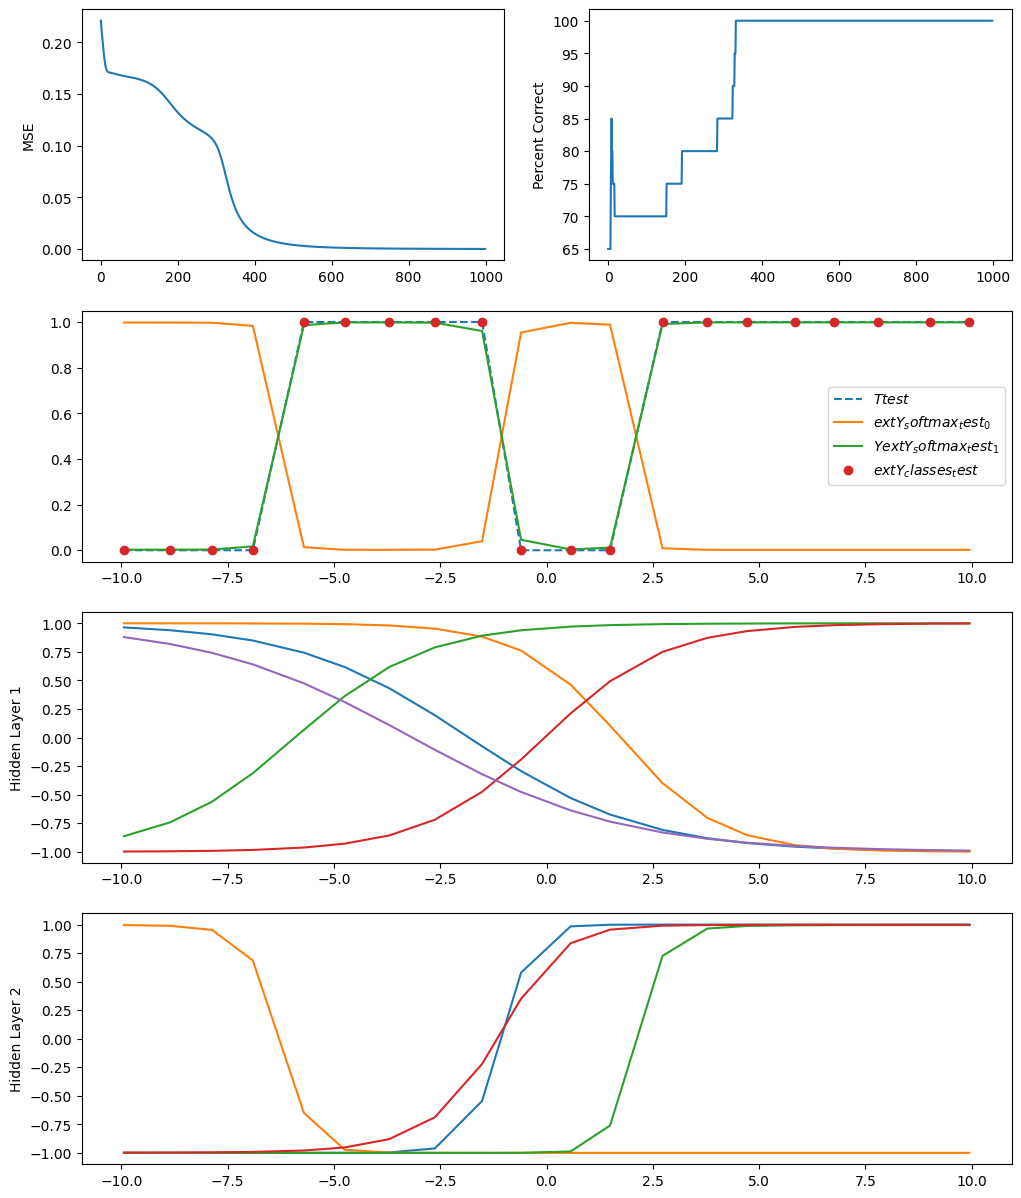

In [19]:
plt.figure(figsize=(12, 15))

plt.subplot(4, 2, 1)
plt.plot(model.mse_trace)
plt.ylabel('MSE')

plt.subplot(4, 2, 2)
plt.plot(model.percent_correct_trace)
plt.ylabel('Percent Correct')

plt.subplot(4, 1, 2)
plt.plot(Xtest, Ttest, '--')
plt.plot(Xtest, Y_softmax_test)
plt.plot(Xtest, Y_classes_test, 'o')
plt.legend(('$Ttest$', '$\text{Y_softmax_test}_0$', 
            '$Y\text{Y_softmax_test}_1$', '$\text{Y_classes}_test$'))

plt.subplot(4, 1, 3)
plt.plot(Xtest, model.H1)
plt.ylabel('Hidden Layer 1')

plt.subplot(4, 1, 4)
plt.plot(Xtest, model.H2)
plt.ylabel('Hidden Layer 2');

##  <font color="red">**30 points**</font>: Experiment with Titanic Data

### Download and read the data

Prepare the titanic data as you did in Assignment 3.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('titanic.csv')
X_names = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
X_df = df[X_names]
sex_to_int = {'male': 0, 'female':1}
X_df = X_df.replace({'Sex': sex_to_int})
X = X_df.values
Survived = ['Survived']
T = df[Survived].values

### Partition the data into train and test sets.

Okay. We have our data.  Let's randomly take 80% of the data for training and the remainder for testing.

In [21]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)

n_train = int(len(rows) * 0.8)
Xtrain = X[rows[:n_train]]
Ttrain = T[rows[:n_train]]

Xtest = X[rows[n_train:]]
Ttest = T[rows[n_train:]]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((709, 6), (709, 1), (178, 6), (178, 1))

### Train and test your NeuralNetwork model on the Titanic data.

Investigate the effects of the number of hidden units, the learning rate, and the number of epochs by defining three nested for loops that iterate over:
* hidden units: `[[1, 1], [5, 5], [10, 10], [20, 20], [50, 50]]`
* learning rate: `[0.001, 0.01, 0.1, 0.2]`
* number of epochs: `[10, 100, 1000, 2000]`

For each combination of these values, create a `NeuralNetwork`, train it on the training data, calculate the percent correct on training data and the percent correct on testing data, and append the result to a list named `results`.  Append a list containing the hidden units list (of two ints), the learning rate, the number of epochs, the training data percent correct and the testing data percent correct.

When this finishes, create a `pandas.DataFrame` showing the results.

In [22]:
# Hidden, Learning, and Epoch Lists
hidden_units_array = [[1, 1], [5, 5], [10, 10], [20, 20], [50, 50]]
learning_rate_array = [0.001, 0.01, 0.1, 0.2]
num_of_epochs_array = [10, 100, 1000, 2000]
results = []

#Train NeuralNetwork
for hidden_units in hidden_units_array:
    for learning_rate in learning_rate_array: 
        for num_epochs in num_of_epochs_array:
            
            model = NeuralNetwork(Xtrain.shape[1], n_hiddens_each_layer, classes)
            model.train(Xtrain, Ttrain, num_epochs, learning_rate)
            
            Xtrain_inst, Xtrain_inst2 = model.use(Xtrain)
            train_percent_correct = model.percent_correct(Xtrain_inst, Ttrain)
            Xtrain_inst3, Xtrain_inst4 = model.use(Xtest)
            test_percent_correct = model.percent_correct(Xtrain_inst3, Ttest)
            
            results.append([hidden_units, learning_rate, num_epochs, train_percent_correct, test_percent_correct])

In [23]:
df = pd.DataFrame(results, columns=('hidden_units', 'lr', 'ne', 'pc_train', 'pc_test'))

Sort the results based on training percent correct and again based on testing percent correct.

In [24]:
pd.set_option('display.max_rows', None)
print('Training data')
print(df.sort_values(by='pc_train', ascending=False))
print('Testing data')
print(df.sort_values(by='pc_test', ascending=False))

Training data
   hidden_units     lr    ne   pc_train    pc_test
27       [5, 5]  0.100  2000  86.882934  78.089888
31       [5, 5]  0.200  2000  86.600846  76.966292
75     [50, 50]  0.100  2000  85.895628  77.528090
47     [10, 10]  0.200  2000  85.754584  78.651685
78     [50, 50]  0.200  1000  85.613540  78.089888
30       [5, 5]  0.200  1000  85.613540  78.089888
14       [1, 1]  0.200  1000  85.613540  76.966292
63     [20, 20]  0.200  2000  85.472496  79.213483
59     [20, 20]  0.100  2000  85.472496  76.404494
15       [1, 1]  0.200  2000  85.472496  77.528090
43     [10, 10]  0.100  2000  85.331453  78.089888
10       [1, 1]  0.100  1000  85.331453  75.842697
42     [10, 10]  0.100  1000  85.331453  75.842697
79     [50, 50]  0.200  2000  85.190409  77.528090
11       [1, 1]  0.100  2000  85.190409  77.528090
58     [20, 20]  0.100  1000  85.190409  77.528090
62     [20, 20]  0.200  1000  85.049365  76.404494
74     [50, 50]  0.100  1000  84.908322  76.404494
46     [10, 10]  

Describe what you in these tables.  Discuss the effects of the hidden units, learning rate, and epochs on your results. Which values of these parameters are best?  Did your neural network do any better than our linear model in Assignment 3?

There are two tables one that shows the results for the testing and the other for the training data. Both tables show similair results with pc_train and pc_test starting around 80% and they both fall to around 20%. This is due to the factors like the learning rate, # of epochs, and the # of hidden units. One of the major factors in the pc_train and pc_test is the learning rate. Where 0.100 and 0.200 had much higher results than the instances where the learning rate was 0.010 and 0.001. The next factor, is the number of epochs in the instance. The pc_train and pc_test have a positive correlation the higher the # of epochs the higher the percentage was. The last factor is the number of hidden units. Like the rest the number of hidden units had a positive correlation with the percent correct. As far as the best paremeters go, the best values based upon this data is:

- learning rate: 0.200
- epochs: 2000
- hidden units: [50,50]

Yes this model did way better job interms of percent correct than our linear model and displaying the effects of all three factors plainly. This model was very easy to understand and determine what the data means.   